In [1]:
def set_paths():
    '''
    Deployment should be something like "dirs/dir1/use-cases"
    This function adds to the path "dirs/dir1/use-cases" and "dirs/dir1/"
    :return:
    '''
    import imp
    from os.path import dirname
    import os
    import sys

    USE_CASES = "/var/SP/data/home/asaezco/src/devel2/use-cases"#dirname(os.path.abspath(imp.find_module('churn')[1]))
    sys.path.append("/var/SP/data/home/asaezco/src/devel2/pykhaos")
    if USE_CASES not in sys.path:
        sys.path.append(USE_CASES)
        print("Added '{}' to path".format(USE_CASES))

    # if deployment is correct, this path should be the one that contains "use-cases", "pykhaos", ...
    # FIXME another way of doing it more general?
    DEVEL_SRC = os.path.dirname(USE_CASES)  # dir before use-cases dir
    if DEVEL_SRC not in sys.path:
        sys.path.append(DEVEL_SRC)
        print("Added '{}' to path".format(DEVEL_SRC))
set_paths()

Added '/var/SP/data/home/asaezco/src/devel2/use-cases' to path
Added '/var/SP/data/home/asaezco/src/devel2' to path


In [2]:
# coding=utf-8

import sys

from common.src.main.python.utils.hdfs_generic import *
import argparse
import os
import sys
import time
from pyspark.sql.functions import (udf,
                                    col,
                                    decode,
                                    when,
                                    lit,
                                    lower,
                                    concat,
                                    translate,
                                    count,
                                    sum as sql_sum,
                                    max as sql_max,
                                    min as sql_min,
                                    avg as sql_avg,
                                    greatest,
                                    least,
                                    isnull,
                                    isnan,
                                    struct, 
                                    substring,
                                    size,
                                    length,
                                    year,
                                    month,
                                    dayofmonth,
                                    unix_timestamp,
                                    date_format,
                                    from_unixtime,
                                    datediff,
                                    to_date, 
                                    desc,
                                    asc,
                                    countDistinct,
                                    row_number,
                                    skewness,
                                    kurtosis,
                                    concat_ws)

from pyspark.sql import Row, DataFrame, Column, Window
from pyspark.sql.types import DoubleType, StringType, IntegerType, DateType, ArrayType
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer, VectorAssembler, SQLTransformer, OneHotEncoder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from datetime import datetime
from itertools import chain
import numpy as np
from functools import reduce
from utils_general import *
from pykhaos.utils.date_functions import convert_to_date
from utils_model import *
from utils_fbb_churn import *
from metadata_fbb_churn import *
from feature_selection_utils import *
import subprocess


In [3]:
# Para que no haga falta recargar el notebook si hacemos un cambio en alguna de las funciones que estamos importando
%load_ext autoreload
%autoreload 2

In [4]:
# set BDP parameters
def setting_bdp(min_n_executors = 3, max_n_executors = 15, n_cores = 8, executor_memory = "12g", driver_memory="8g",
                   app_name = "Python app", driver_overhead="1g", executor_overhead='3g'):

    MAX_N_EXECUTORS = max_n_executors
    MIN_N_EXECUTORS = min_n_executors
    N_CORES_EXECUTOR = n_cores
    EXECUTOR_IDLE_MAX_TIME = 120
    EXECUTOR_MEMORY = executor_memory
    DRIVER_MEMORY = driver_memory
    N_CORES_DRIVER = 1
    MEMORY_OVERHEAD = N_CORES_EXECUTOR * 2048
    QUEUE = "root.BDPtenants.es.low"
    BDA_CORE_VERSION = "1.0.0"

    SPARK_COMMON_OPTS = os.environ.get('SPARK_COMMON_OPTS', '')
    SPARK_COMMON_OPTS += " --executor-memory %s --driver-memory %s" % (EXECUTOR_MEMORY, DRIVER_MEMORY)
    SPARK_COMMON_OPTS += " --conf spark.shuffle.manager=tungsten-sort"
    SPARK_COMMON_OPTS += "  --queue %s" % QUEUE

    # Dynamic allocation configuration
    SPARK_COMMON_OPTS += " --conf spark.dynamicAllocation.enabled=true"
    SPARK_COMMON_OPTS += " --conf spark.shuffle.service.enabled=true"
    SPARK_COMMON_OPTS += " --conf spark.dynamicAllocation.maxExecutors=%s" % (MAX_N_EXECUTORS)
    SPARK_COMMON_OPTS += " --conf spark.dynamicAllocation.minExecutors=%s" % (MIN_N_EXECUTORS)
    SPARK_COMMON_OPTS += " --conf spark.executor.cores=%s" % (N_CORES_EXECUTOR)
    SPARK_COMMON_OPTS += " --conf spark.dynamicAllocation.executorIdleTimeout=%s" % (EXECUTOR_IDLE_MAX_TIME)
    # SPARK_COMMON_OPTS += " --conf spark.ui.port=58235"
    SPARK_COMMON_OPTS += " --conf spark.port.maxRetries=100"
    SPARK_COMMON_OPTS += " --conf spark.app.name='%s'" % (app_name)
    SPARK_COMMON_OPTS += " --conf spark.submit.deployMode=client"
    SPARK_COMMON_OPTS += " --conf spark.ui.showConsoleProgress=true"
    SPARK_COMMON_OPTS += " --conf spark.sql.broadcastTimeout=1200"
    SPARK_COMMON_OPTS += " --conf spark.yarn.executor.memoryOverhead={}".format(executor_overhead)
    SPARK_COMMON_OPTS += " --conf spark.yarn.executor.driverOverhead={}".format(driver_overhead)

    BDA_ENV = os.environ.get('BDA_USER_HOME', '')

    # Attach bda-core-ra codebase
    SPARK_COMMON_OPTS+=" --files {}/scripts/properties/red_agent/nodes.properties,{}/scripts/properties/red_agent/nodes-de.properties,{}/scripts/properties/red_agent/nodes-es.properties,{}/scripts/properties/red_agent/nodes-ie.properties,{}/scripts/properties/red_agent/nodes-it.properties,{}/scripts/properties/red_agent/nodes-pt.properties,{}/scripts/properties/red_agent/nodes-uk.properties".format(*[BDA_ENV]*7)

    os.environ["SPARK_COMMON_OPTS"] = SPARK_COMMON_OPTS
    os.environ["PYSPARK_SUBMIT_ARGS"] = "%s pyspark-shell " % SPARK_COMMON_OPTS

In [5]:
def get_spark_session(app_name="default name", log_level='INFO', min_n_executors = 3, max_n_executors = 15, n_cores = 4, executor_memory = "12g", driver_memory="8g"):
    HOME_SRC = os.path.join(os.environ.get('BDA_USER_HOME', ''), "src")
    if HOME_SRC not in sys.path:
        sys.path.append(HOME_SRC)


    setting_bdp(app_name=app_name, min_n_executors = min_n_executors, max_n_executors = max_n_executors, n_cores = n_cores, executor_memory = executor_memory, driver_memory=driver_memory)
    from common.src.main.python.utils.hdfs_generic import run_sc
    sc, spark, sql_context = run_sc(log_level=log_level)


    return sc, spark, sql_context

In [6]:
def initialize(app_name, min_n_executors = 3, max_n_executors = 15, n_cores = 4, executor_memory = "12g", driver_memory="8g"):
    import time
    start_time = time.time()

    print("_initialize spark")
    #import pykhaos.utils.pyspark_configuration as pyspark_config
    sc, spark, sql_context = get_spark_session(app_name=app_name, log_level="OFF", min_n_executors = min_n_executors, max_n_executors = max_n_executors, n_cores = n_cores,
                             executor_memory = executor_memory, driver_memory=driver_memory)
    print("Ended spark session: {} secs | default parallelism={}".format(time.time() - start_time,
                                                                         sc.defaultParallelism))
    return spark

In [ ]:
spark = initialize("FBB Improvement ",executor_memory = "32g",min_n_executors = 6,max_n_executors = 15)


_initialize spark


In [ ]:
def getFbbChurnLabeledCarCycles_both(spark, origin, yearmonthday, selcols, horizon = 4):

    cycle = 0
    fini_tmp = yearmonthday
    while cycle < horizon:
        yearmonthday_target = get_next_cycle(fini_tmp, str_fmt="%Y%m%d")
        cycle = cycle + 1
        fini_tmp = yearmonthday_target

    yearmonth = yearmonthday[0:6]

    trfeatdf = getCarNumClienteDf(spark, origin, yearmonthday)

    print("[Info getFbbChurnLabeledCar] " + time.ctime() + " Samples for month " + yearmonthday + ": " + str(trfeatdf.count()))

    # Loading port-out requests and DXs
    # # labmonthlisttr = getMonthSeq(initportmonthtr, lastportmonthtr)

    # Las bajas de fibra pueden venir por:
    #- Solicitudes de baja de fijo
    fixporttr = getFixPortRequestsForCycleList(spark, yearmonthday, yearmonthday_target)
    #- Porque dejen de estar en la lista de clientes
    fixdxtr = getFbbDxsForCycleList(spark,yearmonthday, yearmonthday_target)

    # Labeling: FBB service is labeled as 1 if, during the next time window specified by the horizon, either the associated fixed service requested to be ported out or the FBB was disconnected
    window = Window.partitionBy("num_cliente")

    unbaltrdf = trfeatdf\
    .join(fixporttr, ['msisdn_d'], "left_outer")\
    .na.fill({'label_srv': 0.0})\
    .join(fixdxtr, ['msisdn'], "left_outer")\
    .na.fill({'label_dx': 0.0})\
    .withColumn('tmp', when((col('label_dx')==1.0), 1.0).otherwise(0.0))\
    .withColumn('label_bajas', sql_max('tmp').over(window))\
    .withColumn('tmp2', when((col('label_srv')==1.0), 1.0).otherwise(0.0))\
    .withColumn('label_port', sql_max('tmp2').over(window))\
    .filter(col("rgu")=="fbb")\
    .select(selcols + ['label_port', 'label_bajas'])

    print("[Info getFbbChurnLabeledCar] " + time.ctime() + " Labeled samples for month " + yearmonth + ": " + str(unbaltrdf.count()))

    return unbaltrdf

In [ ]:
set_paths()

from pykhaos.utils.date_functions import *
from utils_fbb_churn import *
global sqlContext

In [ ]:
selcols = getIdFeats() + getCrmFeats() + getBillingFeats() + getMobSopoFeats() + getOrdersFeats()
now = datetime.now()

date_name = str(now.year) + str(now.month).rjust(2, '0') + str(now.day).rjust(2, '0')
origin = '/user/hive/warehouse/tests_es.db/jvmm_amdocs_ids_'

In [ ]:
trcycle_ini = '20190507'  # Training data
    # Number of cycles to gather dismiss requests
horizon = 4
    # Cycle used for CAR and Extra Feats in the test set
ttcycle_ini = '20190607'  # Test data

tr_ttdates = trcycle_ini + '_' + ttcycle_ini

In [ ]:
inittrdf_ini = getFbbChurnLabeledCarCycles_both(spark, origin, trcycle_ini, selcols, horizon)

In [ ]:
inittrdf_ini.printSchema()

In [ ]:
## Reading the Extra Features
dfExtraFeat = spark.read.parquet('/data/udf/vf_es/churn/extra_feats_mod/extra_feats/year={}/month={}/day={}'
                                         .format(int(trcycle_ini[0:4]), int(trcycle_ini[4:6]), int(trcycle_ini[6:8])))

    # Taking only the clients with a fbb service
dfExtraFeatfbb = dfExtraFeat.join(inittrdf_ini, ["num_cliente"], "leftsemi")

dfExtraFeatfbb = dfExtraFeatfbb.cache()
#print "[Info Main FbbChurn] " + time.ctime() + " Count of the ExtraFeats: ", dfExtraFeatfbb.count()

    # Taking the Extra Features of interest and adding their values for num_client when necessary
dfExtraFeatSel, selColumnas = addExtraFeatsEvol(dfExtraFeatfbb)

#print "[Info Main FbbChurn] " + time.ctime() + " Calculating the total value of the extra feats for each number client"

dfillNa = fillNa(spark)
for kkey in dfillNa.keys():
    if kkey not in dfExtraFeatSel.columns:
        dfillNa.pop(kkey, None)

In [ ]:
inittrdf = inittrdf_ini.join(dfExtraFeatSel, ["msisdn", "num_cliente", 'rgu'], how="left").na.fill(dfillNa)

In [225]:
[unbaltrdf, valdf] = inittrdf.randomSplit([0.8, 0.2], 1234)

In [226]:
unbaltrdf = unbaltrdf.cache()
valdf = valdf.cache()

In [227]:
unbaltrdf.groupBy('label_bajas').agg(count('*')).show()
unbaltrdf.groupBy('label_port').agg(count('*')).show()

trdf_port = balance_df2(unbaltrdf, 'label_port')
trdf_dx = balance_df2(unbaltrdf, 'label_bajas')

+-----------+--------+
|label_bajas|count(1)|
+-----------+--------+
|        0.0| 1841247|
|        1.0|   58557|
+-----------+--------+

+----------+--------+
|label_port|count(1)|
+----------+--------+
|       0.0| 1878757|
|       1.0|   21047|
+----------+--------+

[Info balance_df2] Dataframe has been balanced - Total number of rows is 42024
[Info balance_df2] Dataframe has been balanced - Total number of rows is 116964


In [228]:
trdf_dx.groupBy('label_bajas').agg(count('*')).show()
trdf_port.groupBy('label_port').agg(count('*')).show()

+-----------+--------+
|label_bajas|count(1)|
+-----------+--------+
|        0.0|   58407|
|        1.0|   58557|
+-----------+--------+

+----------+--------+
|label_port|count(1)|
+----------+--------+
|       0.0|   20977|
|       1.0|   21047|
+----------+--------+



In [229]:
allFeats = trdf_dx.columns

# Getting only the numeric variables
catCols = [item[0] for item in trdf_dx.dtypes if item[1].startswith('string')]
numerical_feats = list(set(allFeats) - set(list(
        set().union(getIdFeats(), getIdFeats_tr(), getNoInputFeats(), catCols, [c + "_enc" for c in getCatFeatsCrm()],
                    ["label"]))))

noninf_feats = getNonInfFeats(trdf_dx, numerical_feats)

[Info FbbChurn] 1/8 Selecting the features that add information to the model
[Info FbbChurn] 2/8 Selecting the features that add information to the model
[Info FbbChurn] 3/8 Selecting the features that add information to the model
[Info FbbChurn] 4/8 Selecting the features that add information to the model
[Info FbbChurn] 5/8 Selecting the features that add information to the model
[Info FbbChurn] 6/8 Selecting the features that add information to the model
[Info FbbChurn] 7/8 Selecting the features that add information to the model
[Info FbbChurn] 8/8 Selecting the features that add information to the model


# Test

In [ ]:
ttdf_ini = getFbbChurnLabeledCarCycles_both(spark, origin, ttcycle_ini, selcols,horizon)

In [ ]:
dfExtraFeat_tt = spark.read.parquet('/data/udf/vf_es/churn/extra_feats_mod/extra_feats/year={}/month={}/day={}'
                                            .format(int(ttcycle_ini[0:4]), int(ttcycle_ini[4:6]), int(ttcycle_ini[6:8])))
dfExtraFeatfbb_tt = dfExtraFeat_tt.join(ttdf_ini.select('num_cliente'), on='num_cliente', how='leftsemi')

In [ ]:
dfExtraFeatfbb_tt = dfExtraFeatfbb_tt.cache()

In [ ]:
dfExtraFeat_ttSel, selColumnas = addExtraFeatsEvol(dfExtraFeatfbb_tt)

In [ ]:
dfillNa = fillNa(spark)
for kkey in dfillNa.keys():
    if kkey not in dfExtraFeat_ttSel.columns:
        dfillNa.pop(kkey, None)

ttdf = ttdf_ini.join(dfExtraFeat_ttSel, ["msisdn", "num_cliente", 'rgu'], how="left").na.fill(dfillNa)

In [ ]:
featCols = list(set(numerical_feats) - set(noninf_feats + ['label_bajas','label_port']))

In [230]:
assembler = VectorAssembler(inputCols=featCols, outputCol="features")

classifier_port = RandomForestClassifier(featuresCol="features", \
                                        labelCol="label_port", \
                                        maxDepth=20, \
                                        maxBins=32, \
                                        minInstancesPerNode=100, \
                                        impurity="entropy", \
                                        featureSubsetStrategy="sqrt", \
                                        subsamplingRate=0.85, minInfoGain = 0.001, \
                                        numTrees=800, \
                                        seed=1234)  
classifier_dx = RandomForestClassifier(featuresCol="features", \
                                        labelCol="label_bajas", \
                                        maxDepth=18, \
                                        maxBins=32, \
                                        minInstancesPerNode=90, \
                                        impurity="entropy", \
                                        featureSubsetStrategy="sqrt", \
                                        subsamplingRate=0.85, minInfoGain = 0.001, \
                                        numTrees=800, \
                                        seed=1234)     

pipeline_port = Pipeline(stages=[assembler, classifier_port])
pipeline_dx = Pipeline(stages=[assembler, classifier_dx])
    
getScore = udf(lambda prob: float(prob[1]), DoubleType())

In [231]:
model_dx = pipeline_dx.fit(trdf_dx)
calibmodel_dx = get_calibration_function2(spark, model_dx, valdf, 'label_bajas', 10)

[Info Calibration] Training - Num samples in the target class 14720.0
[Info Calibration] Training 0.197749133141, 0.0054347826087
[Info Calibration] Training 0.284460958452, 0.0521739130435
[Info Calibration] Training 0.371172783764, 0.133899456522
[Info Calibration] Training 0.457884609075, 0.26589673913
[Info Calibration] Training 0.544596434386, 0.404483695652
[Info Calibration] Training 0.631308259697, 0.556657608696
[Info Calibration] Training 0.718020085008, 0.687703804348
[Info Calibration] Training 0.80473191032, 0.795380434783
[Info Calibration] Training 0.891443735631, 0.89035326087
+-------------------+--------------------+
|        model_score|         target_prob|
+-------------------+--------------------+
| 0.1977491331412949|0.005434782608695652|
| 0.2844609584524902| 0.05217391304347826|
| 0.3711727837636855| 0.13389945652173912|
|0.45788460907488077| 0.26589673913043477|
| 0.5445964343860761|  0.4044836956521739|
| 0.6313082596972714|  0.5566576086956522|
| 0.718020085

In [ ]:
model_port = pipeline_dx.fit(trdf_port)
calibmodel_port = get_calibration_function2(spark, model_port, valdf, 'label_port', 10)

[Info Calibration] Training - Num samples in the target class 5273.0


In [ ]:
tr_preds_df_dx = model_dx.transform(trdf_dx).withColumn("model_score", getScore(col("probability")).cast(DoubleType()))
tr_calib_preds_df_dx = calibmodel_dx[0].transform(tr_preds_df_dx)

In [ ]:
trPredictionAndLabels_dx = tr_calib_preds_df_dx.select(['calib_model_score', 'label_bajas']).rdd.map(lambda r: (r['calib_model_score'], r['label_bajas']))
trmetrics_dx = BinaryClassificationMetrics(trPredictionAndLabels_dx)

In [ ]:
tt_preds_df_dx = model_dx.transform(ttdf).withColumn("model_score", getScore(col("probability")).cast(DoubleType()))
tt_calib_preds_df_dx = calibmodel_dx[0].transform(tt_preds_df_dx)

In [ ]:
ttPredictionAndLabels_dx = tt_calib_preds_df_dx.select(['calib_model_score', 'label_bajas']).rdd.map(lambda r: (r['calib_model_score'], r['label_bajas']))
ttmetrics_dx = BinaryClassificationMetrics(ttPredictionAndLabels_dx)

In [68]:
print('Bajas:')
print(" Area under ROC(tr) = " + str(trmetrics_dx.areaUnderROC))
print(" Area under ROC(tt) = " + str(ttmetrics_dx.areaUnderROC))    
print(" ")

Bajas:
 Area under ROC(tr) = 0.823272964637
 Area under ROC(tt) = 0.749701074505
 


In [276]:
feat_imp = model_dx.stages[1].featureImportances.toArray()

In [277]:
idx = np.argsort(feat_imp)[::-1]

In [278]:
feat_array = np.asarray(featCols)

In [279]:
inf = 0
sup = 10
idxs = idx[inf:sup]
imps = feat_imp[idxs]

In [ ]:
tr_preds_df_port = model_port.transform(trdf_port).withColumn("model_score", getScore(col("probability")).cast(DoubleType()))
tr_calib_preds_df_port = calibmodel_port[0].transform(tr_preds_df_port)

In [ ]:
trPredictionAndLabels_port = tr_calib_preds_df_port.select(['calib_model_score', 'label_port']).rdd.map(lambda r: (r['calib_model_score'], r['label_port']))
trmetrics_port = BinaryClassificationMetrics(trPredictionAndLabels_port)

In [ ]:
tt_preds_df_port = model_port.transform(ttdf).withColumn("model_score", getScore(col("probability")).cast(DoubleType()))
tt_calib_preds_df_port = calibmodel_port[0].transform(tt_preds_df_port)

In [ ]:
ttPredictionAndLabels_port = tt_calib_preds_df_port.select(['calib_model_score', 'label_port']).rdd.map(lambda r: (r['calib_model_score'], r['label_port']))
ttmetrics_port = BinaryClassificationMetrics(ttPredictionAndLabels_port)

In [275]:
print('Portas:')
print(" Area under ROC(tr) = " + str(trmetrics_port.areaUnderROC))
print(" Area under ROC(tt) = " + str(ttmetrics_port.areaUnderROC))    
print(" ")

Portas:
 Area under ROC(tr) = 0.823359590291
 Area under ROC(tt) = 0.768010833482
 


In [280]:
feat_imp_p = model_port.stages[1].featureImportances.toArray()

In [281]:
idx_p = np.argsort(feat_imp_p)[::-1]

In [282]:
feat_array = np.asarray(featCols)

In [283]:
inf = 0
sup = 10
idxs_p = idx_p[inf:sup]

In [284]:
feats_bajas = zip(feat_array[idxs], imps)

In [285]:
feats_portas = zip(feat_array[idx_p], feat_imp_p[idx_p])

In [286]:
feats_bajas

[('tgs_days_until_fecha_fin_dto', 0.026755082885313246),
 ('tgs_days_until_f_fin_bi', 0.024258038473936216),
 ('ccc_most_common_bucket_interactions_total', 0.022233309723642174),
 ('ccc_num_interactions_total', 0.01997226553463553),
 ('ccc_num_diff_buckets_total', 0.01906902817523192),
 ('ccc_days_since_first_interaction_total', 0.018547193265722434),
 ('ccc_bucket_churn_cancellations_total', 0.01777863475096063),
 ('days_since_last_order', 0.016602971447993144),
 ('ccc_days_since_latest_interaction_total', 0.015805342450634745),
 ('tgs_days_since_f_inicio_bi', 0.012426929267179353)]

In [287]:
feats_portas

[('tgs_days_until_fecha_fin_dto', 0.050547313170559625),
 ('tgs_days_until_f_fin_bi', 0.046240484723219094),
 ('tgs_days_since_f_inicio_bi', 0.023161199275346166),
 ('Bill_N1_Tax_Amount', 0.018554534141308233),
 ('ccc_num_interactions_total', 0.015133578397085736),
 ('ccc_bucket_churn_cancellations_total', 0.014545347840190567),
 ('ccc_num_diff_buckets_total', 0.014166576950426772),
 ('max_dias_desde_fx_srv_basic', 0.013687391862213238),
 ('dias_desde_fixed_fx_first', 0.013686711072657147),
 ('dias_desde_movil_fx_first', 0.013504678445477942),
 ('Bill_N1_InvoiceCharges', 0.01294928435135925),
 ('ccc_days_since_first_interaction_total', 0.012838540091215527),
 ('bill_n1_net', 0.012834162787582884),
 ('Bill_N1_Amount_To_Pay', 0.012102003794910532),
 ('mean_dias_desde_fx_srv_basic', 0.011498863214104524),
 ('ccc_days_since_latest_interaction_total', 0.010962978962426932),
 ('Bill_N2_Tax_Amount', 0.010510938345863965),
 ('total_penal_srv_pending_n1_penal_amount', 0.010488629377958844),
 ('

In [ ]:
tt_calib_preds_df_dx.printSchema()

In [ ]:
tt_calib_preds_df_port_ = tt_calib_preds_df_port.withColumnRenamed('calib_model_score', 'calib_model_score_portas')

In [ ]:
tt_calib_preds_df_dx_ = tt_calib_preds_df_dx.withColumnRenamed('calib_model_score', 'calib_model_score_bajas')

In [ ]:
joined = tt_calib_preds_df_port_.select('num_cliente', 'label_port','calib_model_score_portas').join(tt_calib_preds_df_dx_.select('num_cliente', 'label_bajas', 'calib_model_score_bajas'), ['num_cliente'], 'inner')

In [ ]:
tt_calib_preds_df_dx_.count()

In [ ]:
tt_calib_preds_df_port_.count()

In [ ]:
joined.count()

In [ ]:
joined.printSchema()

In [ ]:
from pyspark.sql.functions import greatest, least

joined = joined.withColumn('label', greatest('label_port','label_bajas'))

In [ ]:
joined.printSchema()

In [ ]:
ensembled = joined.withColumn('max', greatest('calib_model_score_portas','calib_model_score_bajas')).withColumn('min', least('calib_model_score_portas','calib_model_score_bajas'))\
.withColumn('mean', (col('calib_model_score_portas')+col('calib_model_score_bajas'))/2)

In [ ]:
pred_min = ensembled.select(['min', 'label']).rdd.map(lambda r: (r['min'], r['label']))
pred_min_metrics = BinaryClassificationMetrics(pred_min)

In [ ]:
pred_max = ensembled.select(['max', 'label']).rdd.map(lambda r: (r['max'], r['label']))
pred_max_metrics = BinaryClassificationMetrics(pred_max)

In [ ]:
pred_mean = ensembled.select(['mean', 'label']).rdd.map(lambda r: (r['mean'], r['label']))
pred_mean_metrics = BinaryClassificationMetrics(pred_mean)

In [69]:
print(" Area under ROC(tt) max = " + str(pred_max_metrics.areaUnderROC)) 
print(" Area under ROC(tt) min = " + str(pred_min_metrics.areaUnderROC))
print(" Area under ROC(tt) mean = " + str(pred_mean_metrics.areaUnderROC)) 

 Area under ROC(tt) max = 0.741575492277
 Area under ROC(tt) min = 0.690853620376
 Area under ROC(tt) mean = 0.730925344592


In [70]:
ensembled.stat.corr("calib_model_score_portas", "calib_model_score_bajas")

0.794068271931153

In [ ]:
arr_port = [float(row['calib_model_score_portas']) for row in ensembled.select('calib_model_score_portas').collect()]

In [ ]:
arr_bajas = [float(row['calib_model_score_bajas']) for row in ensembled.select('calib_model_score_bajas').collect()]

In [ ]:
import matplotlib.pyplot as plt

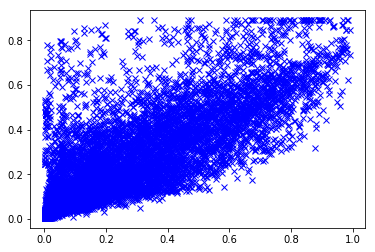

In [289]:
plt.plot(arr_port[:10000], arr_bajas[:10000], 'x', color='blue')

In [71]:
feat_importance_port = getOrderedRelevantFeats(model_port, featCols, 'f', 'rf')
feat_importance_dx = getOrderedRelevantFeats(model_dx, featCols, 'f', 'rf')

In [83]:
port_imp, imp = zip(*feat_importance_port)
dx_imp, imp_dx = zip(*feat_importance_dx)

In [95]:
n = 200
list_f = port_imp[:n] + dx_imp[:n]

In [98]:
featCols_ensemb =  list(dict.fromkeys(list_f)) + ['calib_model_score_portas', 'calib_model_score_bajas']

In [99]:
len(featCols_ensemb)

238

In [100]:
ensembler_df = tt_calib_preds_df_port_.select('num_cliente','calib_model_score_portas').join(tt_calib_preds_df_dx_.drop('features').drop(col('rawPrediction')).drop(col('probability')), ['num_cliente'], 'inner')

In [101]:
ensembler_df.count()

2338584

In [102]:
assembler_ensemb = VectorAssembler(inputCols=featCols_ensemb, outputCol="features")
classifier_ensemb = RandomForestClassifier(featuresCol="features", \
                                            labelCol="label", \
                                            maxDepth=18, \
                                            maxBins=32, \
                                            minInstancesPerNode=100, \
                                            impurity="entropy", \
                                            featureSubsetStrategy="sqrt", \
                                            subsamplingRate=0.85, minInfoGain = 0.001, \
                                            numTrees=800, \
                                            seed=1234)    
pipeline_ensemb = Pipeline(stages=[assembler_ensemb, classifier_ensemb])

In [103]:
model_ensemb = model_dx.transform(valdf).withColumn("model_score", getScore(col("probability")).cast(DoubleType()))
model_ensemb_calib_bajas = calibmodel_dx[0].transform(model_ensemb).withColumnRenamed('calib_model_score', 'calib_model_score_bajas')

In [106]:
model_ensemb = model_port.transform(model_ensemb_calib_bajas.drop('features').drop(col('probability')).drop(col('prediction')).drop(col('rawPrediction')).drop(col('model_score'))).withColumn("model_score", getScore(col("probability")).cast(DoubleType()))
model_ensemb_calib = calibmodel_port[0].transform(model_ensemb).withColumnRenamed('calib_model_score', 'calib_model_score_portas')

In [111]:
model_ensemb_calib = model_ensemb_calib.withColumn('label', greatest('label_port','label_bajas'))

In [113]:
model_ensemb_fit = pipeline_ensemb.fit(model_ensemb_calib.drop('features').drop(col('probability')).drop(col('prediction')).drop(col('rawPrediction')).drop(col('model_score')))

In [114]:
ensemb_preds_tr = model_ensemb_fit.transform(model_ensemb_calib.drop('features').drop(col('probability')).drop(col('prediction')).drop(col('rawPrediction')).drop(col('model_score')))\
.withColumn("model_score", getScore(col("probability")).cast(DoubleType()))

In [116]:
ensembler_PredAndLabs = ensemb_preds_tr.select(['model_score', 'label']).rdd.map(lambda r: (r['model_score'], r['label']))
trmetrics_ensembled = BinaryClassificationMetrics(ensembler_PredAndLabs)

In [ ]:
print(" Area under ROC(ensemb) max = " + str(trmetrics_ensembled.areaUnderROC)) 

 Area under ROC(ensemb) max = 0.815734114274


In [118]:
ensemb_preds_tt = model_ensemb_fit.transform(ensembler_df.drop('features').drop(col('probability')).drop(col('prediction')).drop(col('rawPrediction')).drop(col('model_score')))\
.withColumn("model_score", getScore(col("probability")).cast(DoubleType()))

In [ ]:
ensemb_preds_tt = ensemb_preds_tt.withColumn('label', greatest('label_port','label_bajas'))

In [ ]:
ensembler_PredAndLabs_tt = ensemb_preds_tt.select(['model_score', 'label']).rdd.map(lambda r: (r['model_score'], r['label']))
ttmetrics_ensembled = BinaryClassificationMetrics(ensembler_PredAndLabs_tt)

In [ ]:
print(" Area under ROC(tt) max = " + str(ttmetrics_ensembled.areaUnderROC)) 

In [125]:
ensemb_preds_tt.printSchema()

root
 |-- num_cliente: string (nullable = true)
 |-- calib_model_score_portas: double (nullable = true)
 |-- msisdn: string (nullable = true)
 |-- rgu: string (nullable = true)
 |-- campo1: string (nullable = true)
 |-- msisdn_d: string (nullable = true)
 |-- nif_cliente: string (nullable = true)
 |-- mean_dias_desde_fx_srv_basic: double (nullable = false)
 |-- movil_services: long (nullable = true)
 |-- tv_services: long (nullable = true)
 |-- total_penal_cust_pending_n3_penal_amount: double (nullable = false)
 |-- x_formato_factura: string (nullable = true)
 |-- x_user_twitter: string (nullable = true)
 |-- total_penal_cust_pending_n4_penal_amount: double (nullable = false)
 |-- dias_desde_bam-movil_fx_first: double (nullable = false)
 |-- max_dias_desde_fx_trybuy_autom_tv: double (nullable = false)
 |-- total_price_tariff: double (nullable = false)
 |-- flg_robinson: string (nullable = true)
 |-- pvr_services: double (nullable = false)
 |-- num_tariff_redl: double (nullable = false)

# Unique Model

Summary of Evaluations

('ttmetrics', 0.7243668438589262)

('trmetrics', 0.78609798431278)

In [ ]:
spark.stop()